## Importazione librerie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error
shap.initjs()
import json
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
from PyPDF2 import PdfReader
import re 
import csv
from rapidfuzz import process, fuzz
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
from scipy.stats import chi2_contingency
from sklearn.metrics import cohen_kappa_score # Per Cohen's Kappa (solo 2 osservatori)


## File completo con tutte le domande

In [2]:
dir=os.getcwd()
print(dir)

c:\Users\Maria Beatrice\Desktop\test\UNIVERSITA\SECONDO anno magistrale\BIGDATA\Big-Data-Analytics\Progetto Big Data


In [3]:
#df_preclinica = pd.read_csv(file_path("area_preclinica_2016_2019_finale.csv"))

# Usa il percorso assoluto per il file clinica
PRECLINICA_PATH= r"output\preclinica\area_preclinica_2016_2019_finale.csv"
CLINICA_PATH = r"output\clinica\area_clinica_2016_2019_finale.csv"
df_preclinica= pd.read_csv(PRECLINICA_PATH)
df_clinica = pd.read_csv(CLINICA_PATH)

df_finale = pd.concat([df_preclinica, df_clinica])
df_finale.to_csv("area_preclinica_clinica_2016_2019_finale.csv", index=False, encoding='utf-8')

# passaggio a jsonl
output_file = "area_preclinica_clinica_2016_2019_finale.jsonl"

# Apri file in scrittura
with open(output_file, "w", encoding="utf-8") as f:
    for _, row in df_finale .iterrows():
        # Costruisci dizionario nel formato richiesto
        json_obj = {
            "question": row["question"],
            "options": [
                {"A": row["A"]},
                {"B": row["B"]},
                {"C": row["C"]},
                {"D": row["D"]},
                {"E": row["E"]}
            ],
            "answer": row["answer"],
            "category": row["macro category"] ,
            "macro_category": row["category"]
        }
        # Scrivi ogni riga come JSON
        f.write(json.dumps(json_obj, ensure_ascii=False) + "\n")


## estrazione sottocampione

In [4]:
sample = df_finale.sample(n=50, random_state=42)
sample.to_csv("sample.csv", index=False, encoding='utf-8')

# passaggio a jsonl
output_file = "sample.jsonl"

# Apri file in scrittura
with open(output_file, "w", encoding="utf-8") as f:
    for _, row in sample .iterrows():
        # Costruisci dizionario nel formato richiesto
        json_obj = {
            "question": row["question"],
            "options": [
                {"A": row["A"]},
                {"B": row["B"]},
                {"C": row["C"]},
                {"D": row["D"]},
                {"E": row["E"]}
            ],
            "answer": row["answer"],
            "category": row["macro category"] ,
            "macro_category": row["category"]
        }
        # Scrivi ogni riga come JSON
        f.write(json.dumps(json_obj, ensure_ascii=False) + "\n")


## Apriamo il csv e creiamo una colonna index

In [80]:
df= pd.read_csv("area_preclinica_clinica_2016_2019_finale.csv")

df["index"] = range(len(df))

df=df[["index"] + [col for col in df.columns if col != "index"]]

df = df.drop(["id", "A", "B", "C", "D", "E"], axis=1)

# togliamo spazi per evitare problemi
df.rename(columns={'macro category': 'macro_category'}, inplace=True)

# creaimo la colonna aerea
df['area'] = df['category'].apply(lambda x: x.split(' ')[1] if len(x.split(' ')) > 1 else None)
#tolgo category
df.drop(columns=['category'], inplace=True)

# Display the updated DataFrame to verify
#print(df)

# Mostra il risultato
df.head()

,index,question,answer,macro_category,area
0,0,in una polmonite da staphylococcus aureus meti...,A,farmacologia,Preclinica
1,1,i farmaci ipoglicemizzanti orali della classe ...,B,farmacologia,Preclinica
2,2,"quale tra i seguenti farmaci antidiabetici, de...",D,farmacologia,Preclinica
3,3,nello shock emorragico il trattamento iniziale...,A,farmacologia,Preclinica
4,4,indicare quale dei seguenti farmaci antitumora...,A,farmacologia,Preclinica


## Unire al dataset di interesse le risposte dei modelli


In [81]:
#Gemma
with open("custom_openai_google_gemma_3_27b_it_area_preclinica_clinica_2016_2019_finale_fast.json", "r", encoding="utf-8") as f:
    json_data_gemma = json.load(f)

# Crea un dizionario index → output
output_by_index_gemma = {entry["index"]: entry["output"] for entry in json_data_gemma["results"]}
print(output_by_index_gemma)

#Llama
with open("custom_openai_meta_llama_llama_4_maverick_area_preclinica_clinica_2016_2019_finale_fast.json", "r", encoding="utf-8") as f:
    json_data_llama = json.load(f)

# Crea un dizionario index → output
output_by_index_llama = {entry["index"]: entry["output"] for entry in json_data_llama["results"]}
print(output_by_index_llama)

## Mistral

with open("custom_openai_mistralai_mistral_small_3.2_24b_instruct_area_preclinica_clinica_2016_2019_finale_fast.json", "r", encoding="utf-8") as f:
    json_data_mistral = json.load(f)

# Crea un dizionario index → output
output_by_index_mistral = {entry["index"]: entry["output"] for entry in json_data_mistral["results"]}
print(output_by_index_mistral)


{0: 'A', 1: 'B', 2: 'D', 3: 'A', 4: 'A', 5: 'A', 6: 'E', 7: 'B', 8: 'E', 9: 'D', 10: 'A', 11: 'D', 12: 'C', 13: 'C', 14: 'D', 15: 'D', 16: 'C', 17: 'A', 18: 'D', 19: 'E', 20: 'E', 21: 'D', 22: 'A', 23: 'B', 24: 'D', 25: 'D', 26: 'B', 27: 'E', 28: 'B', 29: 'B', 30: 'C', 31: 'D', 32: 'A', 33: 'B', 34: 'C', 35: 'E', 36: 'D', 37: 'C', 38: 'C', 39: 'B', 40: 'A', 41: 'C', 42: 'E', 43: 'E', 44: 'A', 45: 'B', 46: 'B', 47: 'B', 48: 'A', 49: 'C', 50: 'E', 51: 'D', 52: 'D', 53: 'D', 54: 'B', 55: 'D', 56: 'D', 57: 'A', 58: 'B', 59: 'B', 60: 'C', 61: 'D', 62: 'B', 63: 'E', 64: 'B', 65: 'B', 66: 'E', 67: 'B', 68: 'B', 69: 'C', 70: 'D', 71: 'E', 72: 'A', 73: 'B', 74: 'B', 75: 'D', 76: 'C', 77: 'E', 78: 'A', 79: 'D', 80: 'A', 81: 'D', 82: 'E', 83: 'C', 84: 'D', 85: 'E', 86: 'B', 87: 'B', 88: 'D', 89: 'B', 90: 'E', 91: 'D', 92: 'D', 93: 'C', 94: 'B', 95: 'A', 96: 'C', 97: 'D', 98: 'D', 99: 'A', 100: 'C', 101: 'A', 102: 'B', 103: 'A', 104: 'C', 105: 'B', 106: 'C', 107: 'B', 108: 'D', 109: 'D', 110: 'A',

In [82]:
df["gemma"] = df["index"].apply(lambda idx: output_by_index_gemma.get(idx, ""))
df["llama"] = df["index"].apply(lambda idx: output_by_index_llama.get(idx, ""))
df["mistral"] = df["index"].apply(lambda idx: output_by_index_mistral.get(idx, ""))
df.head()

,index,question,answer,macro_category,area,gemma,llama,mistral
0,0,in una polmonite da staphylococcus aureus meti...,A,farmacologia,Preclinica,A,A,A
1,1,i farmaci ipoglicemizzanti orali della classe ...,B,farmacologia,Preclinica,B,B,B
2,2,"quale tra i seguenti farmaci antidiabetici, de...",D,farmacologia,Preclinica,D,D,D
3,3,nello shock emorragico il trattamento iniziale...,A,farmacologia,Preclinica,A,A,A
4,4,indicare quale dei seguenti farmaci antitumora...,A,farmacologia,Preclinica,A,A,A


In [83]:
df.to_csv("prova_1.csv", index=False, encoding='utf-8')

In [84]:

# Definisci le risposte standard attese
standard_responses = ['A', 'B', 'C', 'D', 'E']

print("--- Verifica Risposte Non Standard nella Colonna 'mistral' ---")
print(f"Risposte standard attese: {standard_responses}")

# Filtra le righe dove la risposta di 'mistral' NON è tra le risposte standard
non_standard_mistral_responses = df[~df['mistral'].isin(standard_responses)]

if non_standard_mistral_responses.empty:
    print("\nNessuna risposta nella colonna 'mistral' è diversa da A, B, C, D, E.")
else:
    # Stampa solo la lunghezza del DataFrame filtrato
    print(non_standard_mistral_responses['mistral'].value_counts())
    print(f"\nNumero totale di risposte non standard di 'mistral': {len(non_standard_mistral_responses)}")

print("\n--- Verifica Risposte Non Standard nella Colonna 'gemma' ---")
non_standard_gemma_responses = df[~df['gemma'].isin(standard_responses)]
if non_standard_gemma_responses.empty:

    print("Nessuna risposta nella colonna 'gemma' è diversa da A, B, C, D, E.")
else:
    # Stampa solo la lunghezza del DataFrame filtrato
    print(non_standard_gemma_responses['gemma'].value_counts())
    print(f"Numero totale di risposte non standard di 'gemma': {len(non_standard_gemma_responses)}")

print("\n--- Verifica Risposte Non Standard nella Colonna 'llama' ---")
non_standard_llama_responses = df[~df['llama'].isin(standard_responses)]
if non_standard_llama_responses.empty:
    print("Nessuna risposta nella colonna 'llama' è diversa da A, B, C, D, E.")
else:
    # Stampa solo la lunghezza del DataFrame filtrato
    print(non_standard_llama_responses['llama'].value_counts())
    print(f"Numero totale di risposte non standard di 'llama': {len(non_standard_llama_responses)}")

--- Verifica Risposte Non Standard nella Colonna 'mistral' ---
Risposte standard attese: ['A', 'B', 'C', 'D', 'E']
mistral
A)                                                                                                               6
B)                                                                                                               3
E)                                                                                                               3
C)                                                                                                               2
A\nB\nD\nE                                                                                                       2
A\nB\nC                                                                                                          1
B) ipertrigliceridemia\nC) iperchilomicronemia\nD) forma combinata                                               1
D\nE                                                                    

## Togliamo le risposte non standard

In [58]:
models = ['gemma', 'llama', 'mistral']
standard_responses = ['A', 'B', 'C', 'D', 'E']

# --- NUOVO STEP: FILTRAGGIO DEL DATAFRAME ---
# Identifica le domande che contengono ALMENO UNA risposta non standard da QUALSIASI modello
questions_to_remove_mask = pd.Series(False, index=df.index)
for model in models:
    # Se una risposta del modello NON è tra le risposte standard, la riga è da marcare
    questions_to_remove_mask = questions_to_remove_mask | (~df[model].isin(standard_responses))

# Filtra il DataFrame per mantenere SOLO le domande senza risposte non standard
df_filtered = df[~questions_to_remove_mask].copy()

print(f"Dimensioni del DataFrame originale: {df.shape[0]} domande")
print(f"Dimensioni del DataFrame dopo aver rimosso le domande con risposte non standard: {df_filtered.shape[0]} domande")
print(f"Numero di domande rimosse: {df.shape[0] - df_filtered.shape[0]}")

# Aggiorna il DataFrame 'df' con quello filtrato per tutte le analisi successive
df = df_filtered.copy()

Dimensioni del DataFrame originale: 6827 domande
Dimensioni del DataFrame dopo aver rimosso le domande con risposte non standard: 6827 domande
Numero di domande rimosse: 0


### Calcolo accuracy per ogni macro categoria

In [59]:

def compute_accuracy(df, prediction_column):
    return (df["answer"] == df[prediction_column]).mean()

def accuracy_table(df_subset):
    result = df_subset.groupby("macro_category").apply(
        lambda group: pd.Series({
            "accuracy_gemma": compute_accuracy(group, 'gemma'),
            "accuracy_llama": compute_accuracy(group, 'llama'),
            "accuracy_mistral": compute_accuracy(group, 'mistral'),
        })
    ).reset_index()

    # Aggiunge la media per riga (accuracy media tra i modelli)
    result["accuracy_mean"] = result[["accuracy_gemma", "accuracy_llama", "accuracy_mistral"]].mean(axis=1)

    # Calcola la riga di media generale per ogni modello
    mean_row = pd.DataFrame([{
        "macro category": "⚙️ OVERALL",
        "accuracy_gemma": result["accuracy_gemma"].mean(),
        "accuracy_llama": result["accuracy_llama"].mean(),
        "accuracy_mistral": result["accuracy_mistral"].mean(),
        "accuracy_mean": result["accuracy_mean"].mean()
    }])

    mean_row = pd.DataFrame([{
        "macro_category": "⚙️ OVERALL", # Etichetta per la riga di riepilogo complessivo
        # accuracy_gemma (nella riga OVERALL): Accuratezza media di Gemma su tutte le macro-categorie.
        "accuracy_gemma": result["accuracy_gemma"].mean(),
        # accuracy_llama (nella riga OVERALL): Accuratezza media di Llama su tutte le macro-categorie.
        "accuracy_llama": result["accuracy_llama"].mean(),
        # accuracy_mistral (nella riga OVERALL): Accuratezza media di Mistral su tutte le macro-categorie.
        "accuracy_mistral": result["accuracy_mistral"].mean(),
        # accuracy_mean (nella riga OVERALL): Media complessiva dell'accuratezza di tutti i modelli
        # su tutte le macro-categorie. È la media della colonna 'accuracy_mean'.
        "accuracy_mean": result["accuracy_mean"].mean()}])

    # Aggiunge la riga in fondo alla tabella
    result = pd.concat([result, mean_row], ignore_index=True)

    return result


df_preclinica = df[df['area'] == 'Preclinica'].copy()
df_clinica = df[df['area'] == 'Clinica'].copy()

# Calcolo tabelle
accuracy_preclinica = accuracy_table(df_preclinica)
accuracy_clinica = accuracy_table(df_clinica)

# Colonne da colorare
accuracy_columns = ["accuracy_gemma", "accuracy_llama", "accuracy_mistral", "accuracy_mean"]

# Colori coerenti
combined = pd.concat([accuracy_preclinica, accuracy_clinica])
vmin = combined[accuracy_columns].min().min()
vmax = combined[accuracy_columns].max().max()

# Mostra le due tabelle
print("🔬 Accuracy per macro categoria (PRECLINICA):")
display(
    accuracy_preclinica.style
        .background_gradient(subset=accuracy_columns, cmap='RdYlGn', vmin=vmin, vmax=vmax)
        .format({col: "{:.4f}" for col in accuracy_columns})
)

print("🩺 Accuracy per macro categoria (CLINICA):")
display(
    accuracy_clinica.style
        .background_gradient(subset=accuracy_columns, cmap='RdYlGn', vmin=vmin, vmax=vmax)
        .format({col: "{:.4f}" for col in accuracy_columns})
)


🔬 Accuracy per macro categoria (PRECLINICA):


,macro_category,accuracy_gemma,accuracy_llama,accuracy_mistral,accuracy_mean
0,farmacologia,0.8329,0.9252,0.8828,0.8803
1,fisiologia,0.8012,0.8950,0.8167,0.8376
2,morfologia,0.7529,0.9059,0.7971,0.8186
3,patologia,0.8548,0.9192,0.8570,0.8770
4,prevenzione e deontologia medica,0.8282,0.8880,0.8668,0.8610
5,⚙️ OVERALL,0.8140,0.9067,0.8441,0.8549


🩺 Accuracy per macro categoria (CLINICA):


,macro_category,accuracy_gemma,accuracy_llama,accuracy_mistral,accuracy_mean
0,chirurgia generale,0.7767,0.8907,0.8100,0.8258
1,chirurgia specialistica,0.8000,0.8889,0.8267,0.8385
2,medicina interna,0.8472,0.9203,0.8405,0.8693
3,medicina legale e sanità pubblica,0.7751,0.8594,0.8153,0.8166
4,medicina specialistica,0.8264,0.9181,0.8506,0.8650
5,organi di senso,0.7778,0.9136,0.8025,0.8313
6,ostetricia e ginecologia,0.7615,0.8654,0.7538,0.7936
7,pediatria,0.6842,0.8669,0.7430,0.7647
8,radiologia e diagnostica,0.8783,0.9087,0.8739,0.8870
9,⚙️ OVERALL,0.7919,0.8924,0.8129,0.8324


In [60]:

# Supponendo che il tuo DataFrame sia già df
#df = pd.read_csv('il_tuo_file.csv') # Se non lo hai già caricato
# Assicurati che i nomi delle colonne siano esattamente 'answer', 'gemma', 'llama', 'mistral', 'macro category'

# Rinomina la colonna 'macro category' per facilità d'uso se contiene spazi
df.rename(columns={'macro category': 'macro_category'}, inplace=True)

# Lista dei modelli che vuoi analizzare
models = ['gemma', 'llama', 'mistral']

# Creiamo un DataFrame vuoto per raccogliere gli errori
df_errors = pd.DataFrame()

# Iteriamo su ogni modello per trovare le risposte sbagliate
for model in models:
    # Filtra le righe dove la risposta del modello non corrisponde alla risposta corretta
    # Vogliamo mantenere tutte le colonne per poter analizzare la categoria e la domanda
    errors_for_model = df[df[model] != df['answer']].copy()

    # Aggiungi una colonna che indica quale modello ha commesso l'errore
    errors_for_model['model_name'] = model

    # Aggiungi questi errori al DataFrame complessivo degli errori
    df_errors = pd.concat([df_errors, errors_for_model], ignore_index=True)

# Ora df_errors contiene tutte le domande sbagliate, con la categoria e il modello che ha sbagliato
print("Anteprima del dataset degli errori:")
df_errors.head()
#len(df_errors)

Anteprima del dataset degli errori:


,index,question,answer,macro_category,area,gemma,llama,mistral,is_error_gemma,is_error_llama,is_error_mistral,error,model_name
0,11,tutte le beta lattamine indicate sono resisten...,C,farmacologia,Preclinica,D,C,C,True,False,False,True,gemma
1,19,in quale delle seguenti condizioni il trattame...,A,farmacologia,Preclinica,E,A,A,True,False,False,True,gemma
2,35,l'emivita (t ½) di un farmaco è:,C,farmacologia,Preclinica,E,C,B,True,False,True,True,gemma
3,43,"i benefici, ormai stabiliti, della terapia sos...",B,farmacologia,Preclinica,E,B,B,True,False,False,True,gemma
4,44,attraverso quale dei seguenti meccanismi d'azi...,B,farmacologia,Preclinica,A,B,A,True,False,True,True,gemma


In [61]:
df_ms = df_errors[df_errors["macro_category"] == "medicina specialistica"].copy()
len(df_ms)

534

In [62]:
# Conto il numero totale di domande per ogni macro_category nel dataset originale
total_questions_per_category = df['macro_category'].value_counts().reset_index()
total_questions_per_category.columns = ['macro_category', 'total_questions']

# Conto gli errori per ogni modello e macro_category
errors_count_per_model_category = df_errors.groupby(['model_name', 'macro_category']).size().reset_index(name='error_count')

# Merge per aggiungere il conteggio totale delle domande
errors_percentage = pd.merge(errors_count_per_model_category, total_questions_per_category, on='macro_category', how='left')

# Calcola la percentuale di errore
errors_percentage['error_percentage'] = (errors_percentage['error_count'] / errors_percentage['total_questions']) * 100

print("\nPercentuale di errori per modello e categoria:")
print(errors_percentage)


Percentuale di errori per modello e categoria:
   model_name                     macro_category  error_count  \
0       gemma                 chirurgia generale           94   
1       gemma            chirurgia specialistica           45   
2       gemma                       farmacologia           67   
3       gemma                         fisiologia          231   
4       gemma                   medicina interna           46   
5       gemma  medicina legale e sanità pubblica           56   
6       gemma             medicina specialistica          229   
7       gemma                         morfologia           84   
8       gemma                    organi di senso           36   
9       gemma           ostetricia e ginecologia           62   
10      gemma                          patologia          133   
11      gemma                          pediatria          102   
12      gemma   prevenzione e deontologia medica           89   
13      gemma           radiologia e diagn

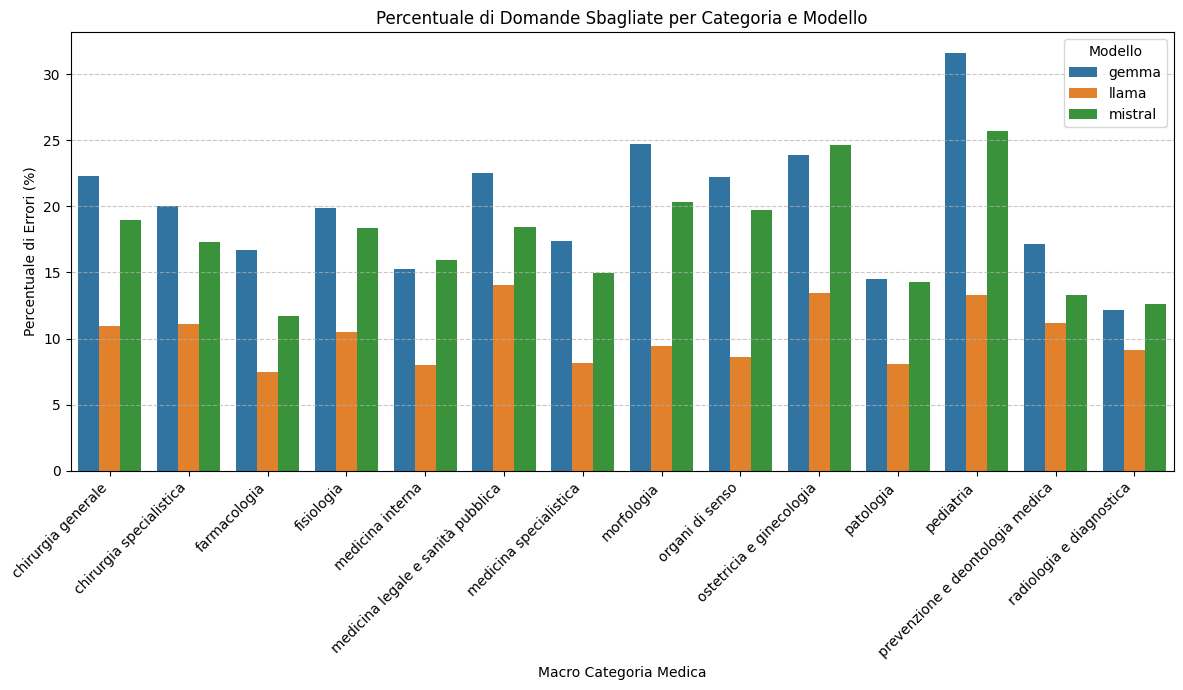

In [63]:
plt.figure(figsize=(12, 7))
sns.barplot(x='macro_category', y='error_percentage', hue='model_name', data=errors_percentage)

plt.title('Percentuale di Domande Sbagliate per Categoria e Modello')
plt.xlabel('Macro Categoria Medica')
plt.ylabel('Percentuale di Errori (%)')
plt.xticks(rotation=45, ha='right') # Ruota le etichette dell'asse x per una migliore leggibilità
plt.legend(title='Modello')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adatta il layout per evitare che le etichette si sovrappongano
plt.show()

In [64]:

# Supponiamo che tu abbia già eseguito i passaggi precedenti
# e che 'df' e 'df_errors' siano popolati come nel codice precedente.

# Conto gli errori per ogni modello e macro_category
errors_count_per_model_category = df_errors.groupby(['model_name', 'macro_category']).size().reset_index(name='error_count')

# Calcola il totale degli errori per ogni modello
total_errors_per_model = errors_count_per_model_category.groupby('model_name')['error_count'].sum().reset_index(name='total_errors')

# Merge per aggiungere il conteggio totale degli errori per ogni modello
errors_distribution = pd.merge(errors_count_per_model_category, total_errors_per_model, on='model_name', how='left')

# Calcola la percentuale della categoria sul totale degli errori del modello
errors_distribution['percentage_of_model_errors'] = (errors_distribution['error_count'] / errors_distribution['total_errors']) * 100

print("Distribuzione percentuale degli errori per categoria all'interno di ogni modello:")
print(errors_distribution.head())
print(errors_distribution.tail())

Distribuzione percentuale degli errori per categoria all'interno di ogni modello:
  model_name           macro_category  error_count  total_errors  \
0      gemma       chirurgia generale           94          1302   
1      gemma  chirurgia specialistica           45          1302   
2      gemma             farmacologia           67          1302   
3      gemma               fisiologia          231          1302   
4      gemma         medicina interna           46          1302   

   percentage_of_model_errors  
0                    7.219662  
1                    3.456221  
2                    5.145929  
3                   17.741935  
4                    3.533026  
   model_name                    macro_category  error_count  total_errors  \
37    mistral          ostetricia e ginecologia           64          1147   
38    mistral                         patologia          131          1147   
39    mistral                         pediatria           83          1147   
40   

## Distribuzione degli errori per ogni modello

Esempio di errors_distribution (calcolo corretto):
                      macro_category  total_errors_in_category  \
0                 chirurgia generale                        94   
1            chirurgia specialistica                        45   
2                       farmacologia                        67   
3                         fisiologia                       231   
4                   medicina interna                        46   
5  medicina legale e sanità pubblica                        56   
6             medicina specialistica                       229   
7                         morfologia                        84   
8                    organi di senso                        36   
9           ostetricia e ginecologia                        62   

   percentage_of_model_errors model_name  
0                    7.219662      gemma  
1                    3.456221      gemma  
2                    5.145929      gemma  
3                   17.741935      gemma  
4      

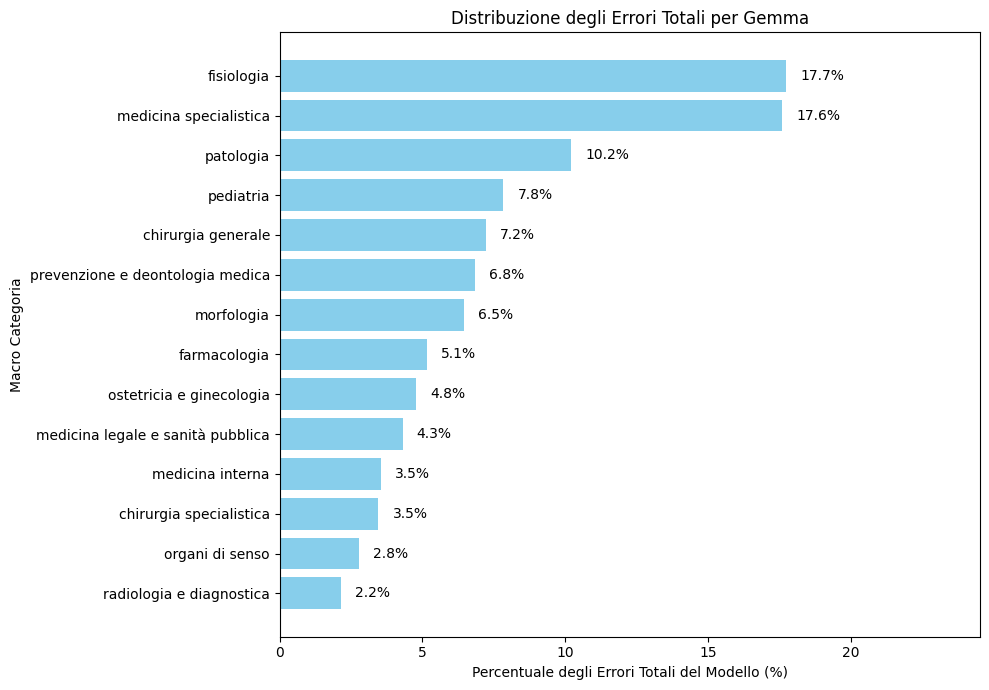

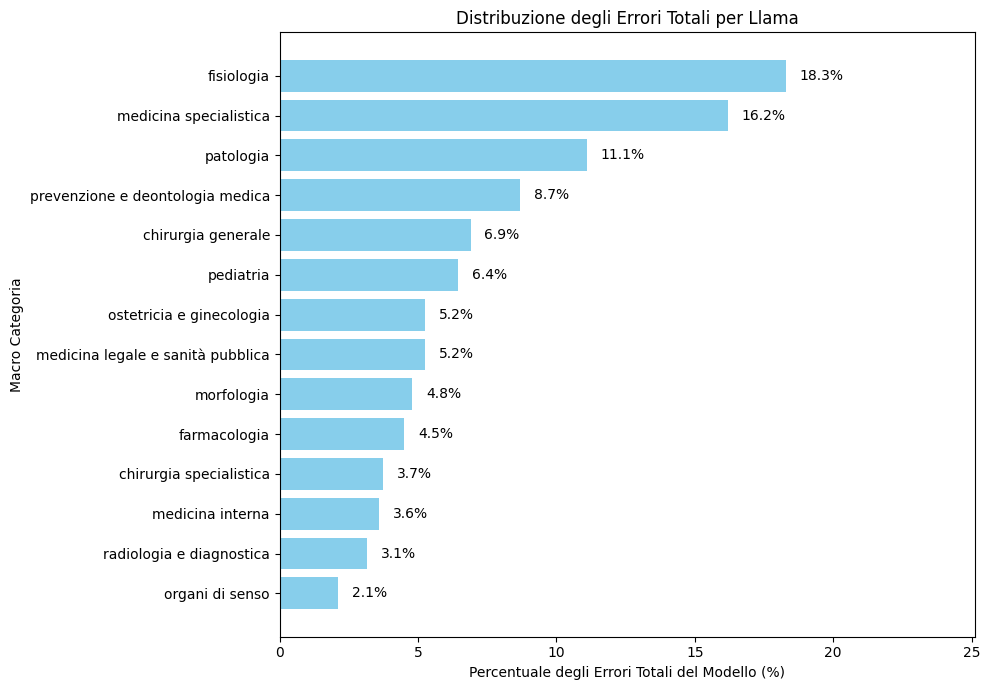

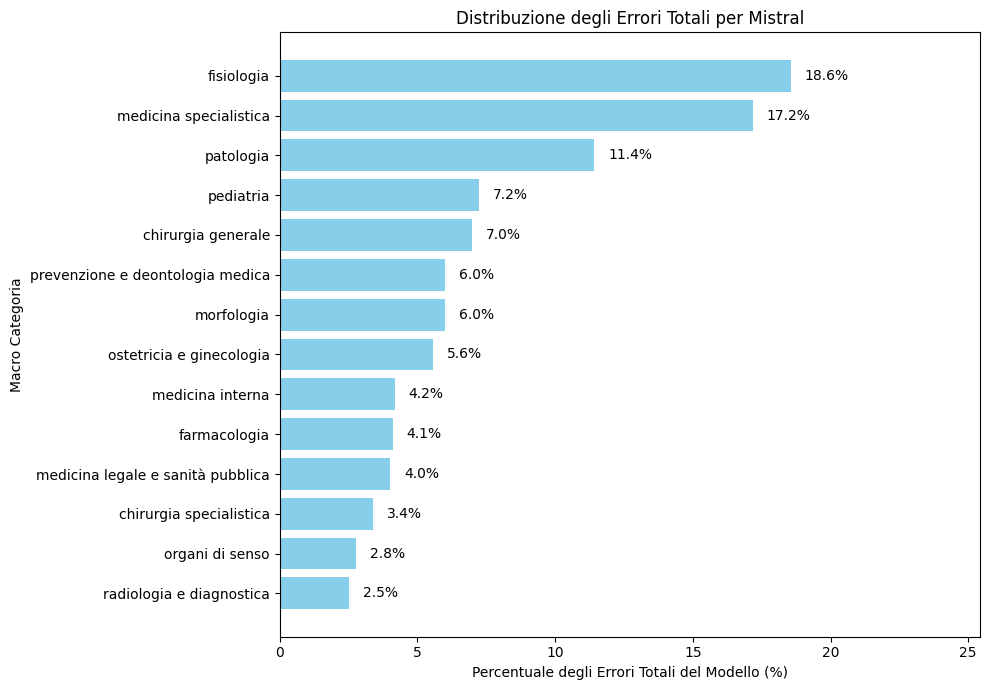

In [65]:
models = ['gemma', 'llama', 'mistral']
# Assicurati di aver filtrato il df_filtered come discusso in precedenza se vuoi rimuovere le risposte non standard
# (Questo esempio usa il df originale, ma tu dovresti usare il df filtrato se ne hai creato uno)


# --- Calcolo corretto di 'errors_distribution' per percentuali che sommano al 100% ---
errors_distribution_list = []

for model_name in models:
    # 1. Identifica gli errori per il modello corrente
    df['is_error_' + model_name] = (df[model_name] != df['answer'])
    
    # 2. Calcola il numero totale di errori che il modello ha commesso nell'intero dataset
    total_errors_for_model = df['is_error_' + model_name].sum()

    # Se il modello non ha commesso errori, aggiungi una riga vuota e salta
    if total_errors_for_model == 0:
        errors_distribution_list.append(pd.DataFrame({
            'model_name': [model_name],
            'macro_category': ['Nessun errore'], # O qualsiasi etichetta tu preferisca
            'total_errors': [0],
            'percentage_of_model_errors': [0.0]
        }))
        continue

    # 3. Calcola il numero di errori per ogni macro_category per il modello corrente
    errors_by_category = df.groupby('macro_category')['is_error_' + model_name].sum().reset_index()
    errors_by_category.rename(columns={'is_error_' + model_name: 'total_errors_in_category'}, inplace=True)

    # 4. Calcola la percentuale di questi errori rispetto al TOTALE degli errori del modello
    errors_by_category['percentage_of_model_errors'] = (errors_by_category['total_errors_in_category'] / total_errors_for_model) * 100
    errors_by_category['model_name'] = model_name

    errors_distribution_list.append(errors_by_category)

errors_distribution = pd.concat(errors_distribution_list, ignore_index=True)

print("Esempio di errors_distribution (calcolo corretto):")
print(errors_distribution.head(n=10)) # Mostra più righe per verificare


# --- Generazione dei diagrammi a barre orizzontali separati ---

# Genera un diagramma a barre orizzontale per ogni modello
for model in models:
    # Filtra i dati per il modello corrente
    model_errors_data = errors_distribution[errors_distribution['model_name'] == model].copy()

    # Prepara i dati per il diagramma a barre
    # Filtra le categorie che hanno 0 errori per quel modello per non visualizzarle
    # E assicurati che ci siano errori da plottare
    plot_data = model_errors_data[model_errors_data['total_errors_in_category'] > 0] # Usa 'total_errors_in_category' per filtrare

    # Se non ci sono errori per il modello, salta il plotting o mostra un messaggio
    if plot_data.empty:
        print(f"\nNessun errore significativo da visualizzare per il modello {model.capitalize()}. Saltando il grafico.")
        continue

    # Ordina i dati dal più grande al più piccolo per visualizzazione
    # ascending=True per mostrare il più grande in alto nelle barre orizzontali
    plot_data = plot_data.sort_values(by='percentage_of_model_errors', ascending=True)

    categories = plot_data['macro_category']
    percentages = plot_data['percentage_of_model_errors']

    # Crea una NUOVA figura per ogni modello
    plt.figure(figsize=(10, max(6, len(categories) * 0.5))) # Regola altezza figura dinamicamente
    ax = plt.gca() # Ottieni gli assi correnti

    # Crea il diagramma a barre orizzontale
    bars = ax.barh(categories, percentages, color='skyblue')

    ax.set_title(f'Distribuzione degli Errori Totali per {model.capitalize()}')
    ax.set_xlabel('Percentuale degli Errori Totali del Modello (%)')
    ax.set_ylabel('Macro Categoria')

    # Aggiungi le percentuali alla fine di ogni barra per chiarezza
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}%',
                va='center', ha='left') # 'ha'='left' per allineamento testo

    # Imposta i limiti dell'asse x
    # Il limite massimo dovrebbe essere leggermente superiore al valore massimo della percentuale
    # per fare spazio alle etichette di testo.
    max_percentage = percentages.max() if not percentages.empty else 0
    ax.set_xlim(0, max_percentage * 1.1 + 5) # Aggiungi un po' di padding per le etichette

    plt.tight_layout() # Regola il layout per evitare sovrapposizioni
    plt.show() # Mostra il grafico corrente prima di passare al prossimo modello

## Adesso lo facciamo dividendo in area clinica e preclinica

In [66]:
df_preclinica = df[df['area'] == 'Preclinica'].copy()
df_clinica = df[df['area'] == 'Clinica'].copy()



Esempio di errors_distribution (calcolo corretto):
                     macro_category  total_errors_in_category  \
0                      farmacologia                        67   
1                        fisiologia                       231   
2                        morfologia                        84   
3                         patologia                       133   
4  prevenzione e deontologia medica                        89   
5                      farmacologia                        30   
6                        fisiologia                       122   
7                        morfologia                        32   
8                         patologia                        74   
9  prevenzione e deontologia medica                        58   

   percentage_of_model_errors model_name  
0                   11.092715      gemma  
1                   38.245033      gemma  
2                   13.907285      gemma  
3                   22.019868      gemma  
4                 

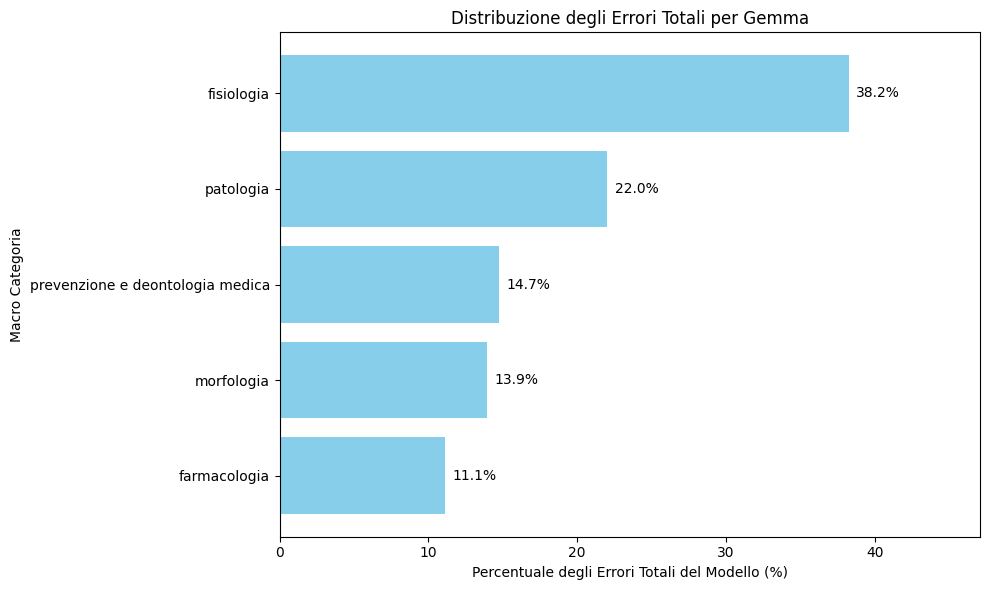

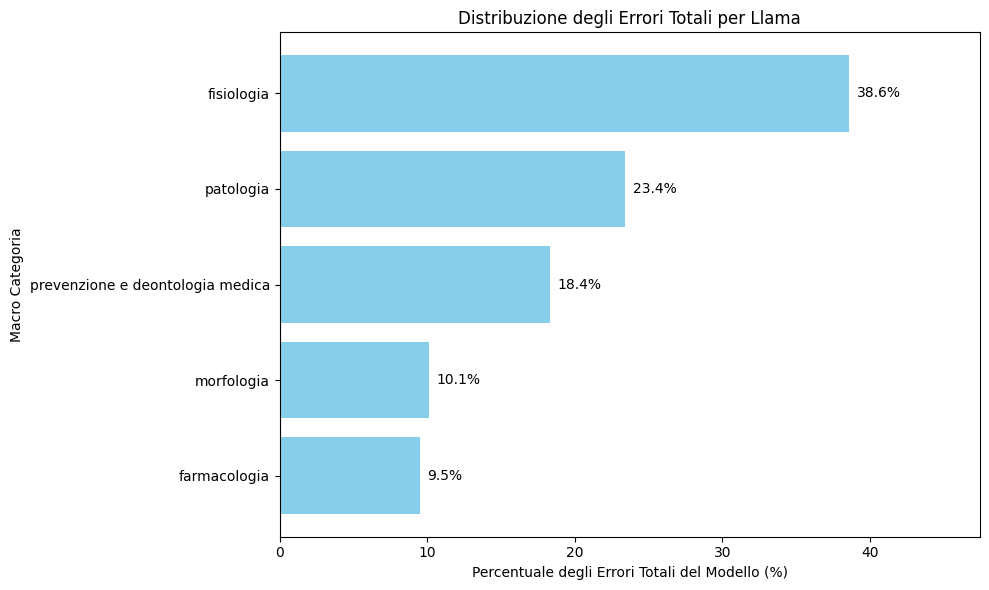

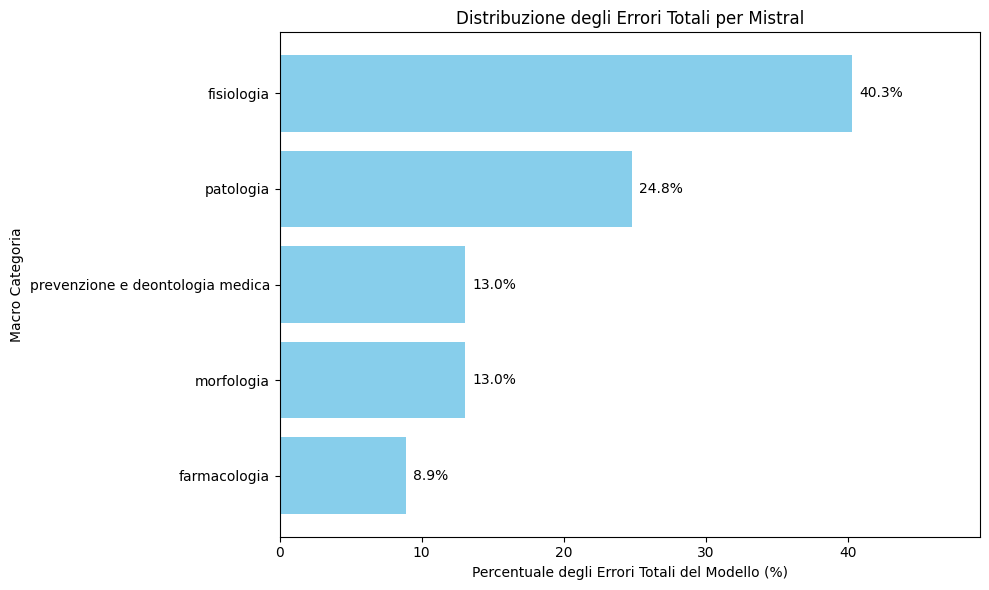

In [67]:
models = ['gemma', 'llama', 'mistral']
# Assicurati di aver filtrato il df_filtered come discusso in precedenza se vuoi rimuovere le risposte non standard
# (Questo esempio usa il df originale, ma tu dovresti usare il df filtrato se ne hai creato uno)


# --- Calcolo corretto di 'errors_distribution' per percentuali che sommano al 100% ---
errors_distribution_list = []

for model_name in models:
    # 1. Identifica gli errori per il modello corrente
    df_preclinica['is_error_' + model_name] = (df_preclinica[model_name] != df_preclinica['answer'])
    
    # 2. Calcola il numero totale di errori che il modello ha commesso nell'intero dataset
    total_errors_for_model = df_preclinica['is_error_' + model_name].sum()

    # Se il modello non ha commesso errori, aggiungi una riga vuota e salta
    if total_errors_for_model == 0:
        errors_distribution_list.append(pd.DataFrame({
            'model_name': [model_name],
            'macro_category': ['Nessun errore'], # O qualsiasi etichetta tu preferisca
            'total_errors': [0],
            'percentage_of_model_errors': [0.0]
        }))
        continue

    # 3. Calcola il numero di errori per ogni macro_category per il modello corrente
    errors_by_category = df_preclinica.groupby('macro_category')['is_error_' + model_name].sum().reset_index()
    errors_by_category.rename(columns={'is_error_' + model_name: 'total_errors_in_category'}, inplace=True)

    # 4. Calcola la percentuale di questi errori rispetto al TOTALE degli errori del modello
    errors_by_category['percentage_of_model_errors'] = (errors_by_category['total_errors_in_category'] / total_errors_for_model) * 100
    errors_by_category['model_name'] = model_name

    errors_distribution_list.append(errors_by_category)

errors_distribution = pd.concat(errors_distribution_list, ignore_index=True)

print("Esempio di errors_distribution (calcolo corretto):")
print(errors_distribution.head(n=10)) # Mostra più righe per verificare


# --- Generazione dei diagrammi a barre orizzontali separati ---

# Genera un diagramma a barre orizzontale per ogni modello
for model in models:
    # Filtra i dati per il modello corrente
    model_errors_data = errors_distribution[errors_distribution['model_name'] == model].copy()

    # Prepara i dati per il diagramma a barre
    # Filtra le categorie che hanno 0 errori per quel modello per non visualizzarle
    # E assicurati che ci siano errori da plottare
    plot_data = model_errors_data[model_errors_data['total_errors_in_category'] > 0] # Usa 'total_errors_in_category' per filtrare

    # Se non ci sono errori per il modello, salta il plotting o mostra un messaggio
    if plot_data.empty:
        print(f"\nNessun errore significativo da visualizzare per il modello {model.capitalize()}. Saltando il grafico.")
        continue

    # Ordina i dati dal più grande al più piccolo per visualizzazione
    # ascending=True per mostrare il più grande in alto nelle barre orizzontali
    plot_data = plot_data.sort_values(by='percentage_of_model_errors', ascending=True)

    categories = plot_data['macro_category']
    percentages = plot_data['percentage_of_model_errors']

    # Crea una NUOVA figura per ogni modello
    plt.figure(figsize=(10, max(6, len(categories) * 0.5))) # Regola altezza figura dinamicamente
    ax = plt.gca() # Ottieni gli assi correnti

    # Crea il diagramma a barre orizzontale
    bars = ax.barh(categories, percentages, color='skyblue')

    ax.set_title(f'Distribuzione degli Errori Totali per {model.capitalize()}')
    ax.set_xlabel('Percentuale degli Errori Totali del Modello (%)')
    ax.set_ylabel('Macro Categoria')

    # Aggiungi le percentuali alla fine di ogni barra per chiarezza
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}%',
                va='center', ha='left') # 'ha'='left' per allineamento testo

    # Imposta i limiti dell'asse x
    # Il limite massimo dovrebbe essere leggermente superiore al valore massimo della percentuale
    # per fare spazio alle etichette di testo.
    max_percentage = percentages.max() if not percentages.empty else 0
    ax.set_xlim(0, max_percentage * 1.1 + 5) # Aggiungi un po' di padding per le etichette

    plt.tight_layout() # Regola il layout per evitare sovrapposizioni
    plt.show() # Mostra il grafico corrente prima di passare al prossimo modello

Esempio di errors_distribution (calcolo corretto):
                      macro_category  total_errors_in_category  \
0                 chirurgia generale                        94   
1            chirurgia specialistica                        45   
2                   medicina interna                        46   
3  medicina legale e sanità pubblica                        56   
4             medicina specialistica                       229   
5                    organi di senso                        36   
6           ostetricia e ginecologia                        62   
7                          pediatria                       102   
8           radiologia e diagnostica                        28   
9                 chirurgia generale                        46   

   percentage_of_model_errors model_name  
0                   13.467049      gemma  
1                    6.446991      gemma  
2                    6.590258      gemma  
3                    8.022923      gemma  
4      

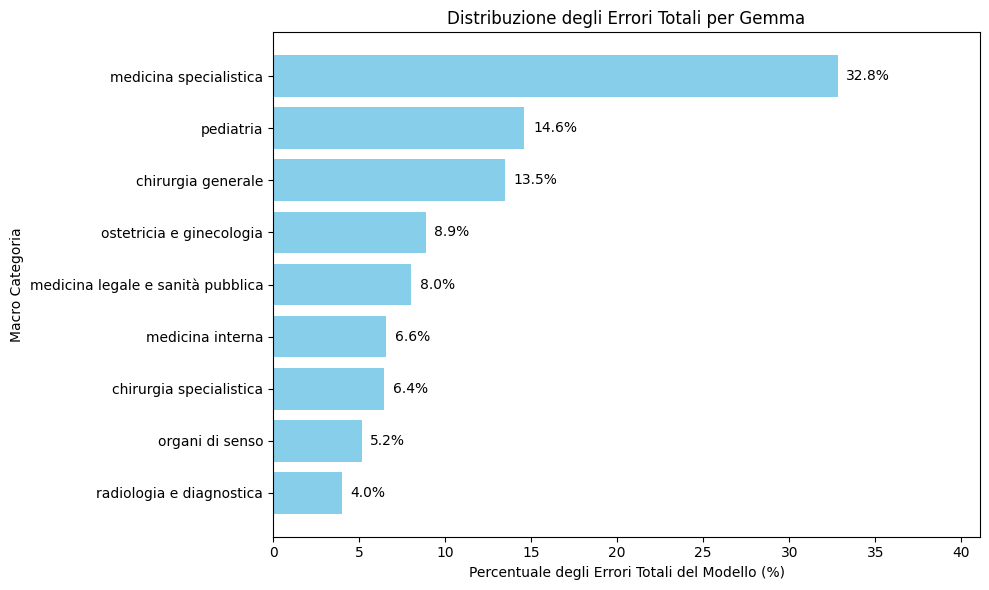

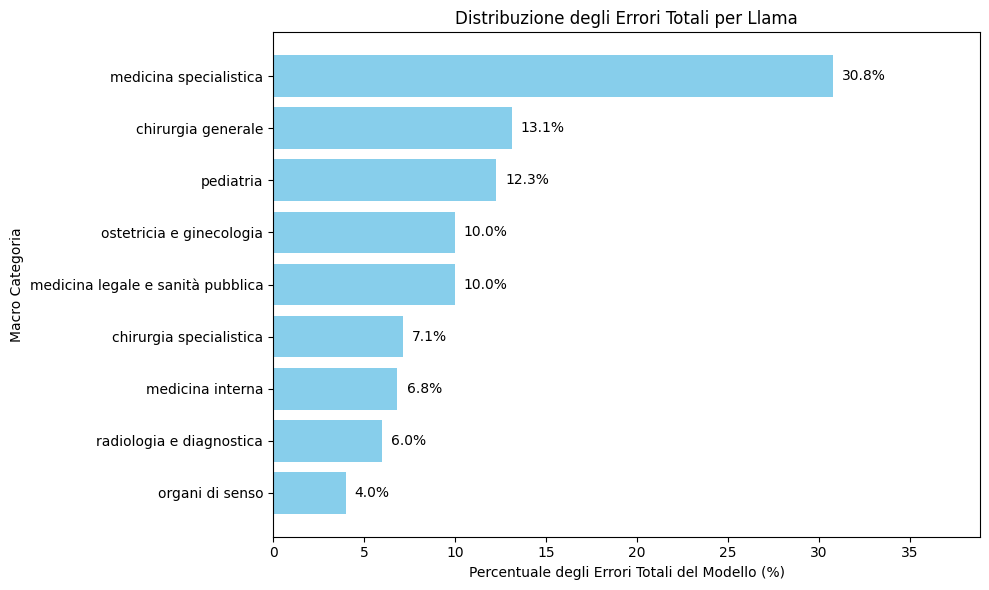

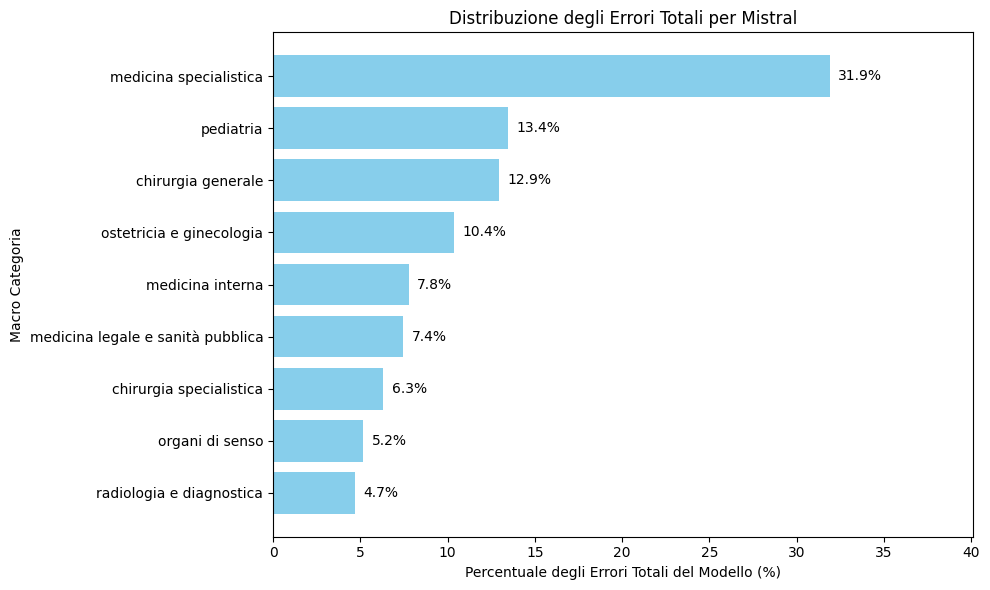

In [68]:
models = ['gemma', 'llama', 'mistral']
# Assicurati di aver filtrato il df_filtered come discusso in precedenza se vuoi rimuovere le risposte non standard
# (Questo esempio usa il df originale, ma tu dovresti usare il df filtrato se ne hai creato uno)


# --- Calcolo corretto di 'errors_distribution' per percentuali che sommano al 100% ---
errors_distribution_list = []

for model_name in models:
    # 1. Identifica gli errori per il modello corrente
    df_clinica['is_error_' + model_name] = (df_clinica[model_name] != df_clinica['answer'])
    
    # 2. Calcola il numero totale di errori che il modello ha commesso nell'intero dataset
    total_errors_for_model = df_clinica['is_error_' + model_name].sum()

    # Se il modello non ha commesso errori, aggiungi una riga vuota e salta
    if total_errors_for_model == 0:
        errors_distribution_list.append(pd.DataFrame({
            'model_name': [model_name],
            'macro_category': ['Nessun errore'], # O qualsiasi etichetta tu preferisca
            'total_errors': [0],
            'percentage_of_model_errors': [0.0]
        }))
        continue

    # 3. Calcola il numero di errori per ogni macro_category per il modello corrente
    errors_by_category = df_clinica.groupby('macro_category')['is_error_' + model_name].sum().reset_index()
    errors_by_category.rename(columns={'is_error_' + model_name: 'total_errors_in_category'}, inplace=True)

    # 4. Calcola la percentuale di questi errori rispetto al TOTALE degli errori del modello
    errors_by_category['percentage_of_model_errors'] = (errors_by_category['total_errors_in_category'] / total_errors_for_model) * 100
    errors_by_category['model_name'] = model_name

    errors_distribution_list.append(errors_by_category)

errors_distribution = pd.concat(errors_distribution_list, ignore_index=True)

print("Esempio di errors_distribution (calcolo corretto):")
print(errors_distribution.head(n=10)) # Mostra più righe per verificare


# --- Generazione dei diagrammi a barre orizzontali separati ---

# Genera un diagramma a barre orizzontale per ogni modello
for model in models:
    # Filtra i dati per il modello corrente
    model_errors_data = errors_distribution[errors_distribution['model_name'] == model].copy()

    # Prepara i dati per il diagramma a barre
    # Filtra le categorie che hanno 0 errori per quel modello per non visualizzarle
    # E assicurati che ci siano errori da plottare
    plot_data = model_errors_data[model_errors_data['total_errors_in_category'] > 0] # Usa 'total_errors_in_category' per filtrare

    # Se non ci sono errori per il modello, salta il plotting o mostra un messaggio
    if plot_data.empty:
        print(f"\nNessun errore significativo da visualizzare per il modello {model.capitalize()}. Saltando il grafico.")
        continue

    # Ordina i dati dal più grande al più piccolo per visualizzazione
    # ascending=True per mostrare il più grande in alto nelle barre orizzontali
    plot_data = plot_data.sort_values(by='percentage_of_model_errors', ascending=True)

    categories = plot_data['macro_category']
    percentages = plot_data['percentage_of_model_errors']

    # Crea una NUOVA figura per ogni modello
    plt.figure(figsize=(10, max(6, len(categories) * 0.5))) # Regola altezza figura dinamicamente
    ax = plt.gca() # Ottieni gli assi correnti

    # Crea il diagramma a barre orizzontale
    bars = ax.barh(categories, percentages, color='skyblue')

    ax.set_title(f'Distribuzione degli Errori Totali per {model.capitalize()}')
    ax.set_xlabel('Percentuale degli Errori Totali del Modello (%)')
    ax.set_ylabel('Macro Categoria')

    # Aggiungi le percentuali alla fine di ogni barra per chiarezza
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}%',
                va='center', ha='left') # 'ha'='left' per allineamento testo

    # Imposta i limiti dell'asse x
    # Il limite massimo dovrebbe essere leggermente superiore al valore massimo della percentuale
    # per fare spazio alle etichette di testo.
    max_percentage = percentages.max() if not percentages.empty else 0
    ax.set_xlim(0, max_percentage * 1.1 + 5) # Aggiungi un po' di padding per le etichette

    plt.tight_layout() # Regola il layout per evitare sovrapposizioni
    plt.show() # Mostra il grafico corrente prima di passare al prossimo modello

In [69]:
# --- NUOVO STEP: Calcolo degli errori per domanda ---

# Crea una copia del DataFrame per non modificare l'originale se non desiderato
df_errors = df.copy()

# Aggiungi una colonna per ogni modello che indica se la sua risposta è errata (True/False)
for model in models:
    df_errors[f'is_error_{model}'] = (df_errors[model] != df_errors['answer'])

# Calcola il numero totale di risposte errate per ogni domanda (sommando i True)
df_errors['total_errors_per_question'] = 0
for model in models:
    df_errors['total_errors_per_question'] += df_errors[f'is_error_{model}'].astype(int)

# Ordina le domande in base al numero di risposte errate (dal più alto al più basso)
wrong_questions_ranking = df_errors.sort_values(
    by='total_errors_per_question',
    ascending=False
)

# Seleziona le colonne desiderate per la classifica
# Puoi includere 'answer' e le risposte dei modelli per vedere quali erano gli errori
columns_to_display = ['question', 'answer'] + models + ['total_errors_per_question', 'macro_category']
wrong_questions_ranking = wrong_questions_ranking[columns_to_display]

print("--- Classifica delle domande con il maggior numero di risposte errate ---")
# Mostra le prime N domande più problematiche
print(wrong_questions_ranking.head(10)) # Mostra le prime 10 domande con più errori, o di meno se non ce ne sono 10
print(f"\nNumero totale di domande con almeno un errore (tra tutti i modelli): {wrong_questions_ranking[wrong_questions_ranking['total_errors_per_question'] > 0].shape[0]}")

# Puoi anche filtrare per mostrare solo le domande che hanno avuto almeno un errore
questions_with_errors = wrong_questions_ranking[wrong_questions_ranking['total_errors_per_question'] > 3]
print("\n--- Tutte le domande con almeno un errore (ordinate) ---")
print(questions_with_errors)

--- Classifica delle domande con il maggior numero di risposte errate ---
                                               question answer gemma llama  \
681   riguardo la curva di dissociazione dell'emoglo...      A     B     B   
6687  l'immagine di "plus" in una radiografia dello ...      E     C     B   
5536  il paziente colpito da poliartrite nodosa freq...      B     A     D   
3577  il collasso di un intero polmone può verificar...      C     D     D   
5963  l'apofisi coronoidea della mandibola da inserz...      A     B     B   
3582  un uomo di 40 anni con una rettocolite ulceros...      D     B     B   
370    qual è il meccanismo d'azione della lamotrigina?      A     E     B   
550   quale tra le seguenti affermazioni riguardanti...      E     A     D   
1227  quale di queste sindromi è associata a disomia...      C     B     B   
6441  un ragazzo di 14 mesi presenta eczema grave, u...      B     A     A   

     mistral  total_errors_per_question            macro_category  

## Calcolare se c'è una relazione significativa tra numero sbagliato di domande del modello e categoria della domanda

In [70]:

models = ['gemma', 'llama', 'mistral']
all_macro_categories = df['macro_category'].unique()
results_summary_final = []

print("--- Generazione delle Tabelle di Contingenza (Errori/Corrette per Modello) per Categoria ---")
print("-----------------------------------------------------------------------------------------")

# Questo loop itera attraverso OGNI SINGOLA macro_category presente nel tuo dataset.
for category_name in all_macro_categories:

    # 1. SELEZIONE DEI DATI PER LA MACRO CATEGORIA ATTUALE
    # Filtriamo il DataFrame 'df' originale per considerare SOLO le domande
    # che appartengono alla 'category_name' corrente (es. 'Cardiologia').
    df_current_category = df[df['macro_category'] == category_name].copy()

    # --- 2. CREAZIONE DELLA CONTINGENCY TABLE PER QUESTA SPECIFICA CATEGORIA ---
    # Questa tabella conterrà i conteggi di "Errori" e "Corrette" per ogni modello,
    # MA SOLO per le domande relative alla 'category_name' attuale.
    contingency_table_data = []
    for model in models:
        # Conta le risposte corrette del modello per le domande di 'category_name'
        correct_count = (df_current_category[model] == df_current_category['answer']).sum()
        # Conta le risposte sbagliate del modello per le domande di 'category_name'
        error_count = (df_current_category[model] != df_current_category['answer']).sum()
        contingency_table_data.append([error_count, correct_count])

    # Creiamo il DataFrame Pandas che rappresenta la nostra contingency table
    # con i nomi dei modelli come indice e 'Errori'/'Corrette' come colonne.
    contingency_table = pd.DataFrame(contingency_table_data, index=models, columns=['Errori', 'Corrette'])

    # --- STAMPA DELLA TABELLA DI CONTINGENZA ATTUALE ---
    print(f"\n#####################################################")
    print(f"### Tabella di Contingenza per: '{category_name}' ###")
    print(f"#####################################################")
    print(contingency_table)
    print("\n" + "="*50) # Separatore visivo

    # A questo punto, se volessi, potresti eseguire il test Chi-quadro QUI,
    # SUBITO DOPO aver stampato la tabella, come negli script precedenti.
    # Esempio (non eseguito in questo blocco, ma per riferimento):
    chi2_val, p_val, dof_val, expected_freq = chi2_contingency(contingency_table)
    print(f"P-value per '{category_name}': {p_val:.4f}")

    results_summary_final.append({
        'Macro_Category': category_name,
        'Chi2_Statistic': chi2_val,
        'P_Value': p_val,
        'Degrees_of_Freedom': dof_val,
    })

    print("\n" + "="*80) # Separatore visivo più lungo per chiarezza tra le categorie

# --- TABELLA RIEPILOGATIVA FINALE ---
print("\n\n--- RIEPILOGO COMPLESSIVO DEI TEST CHI-QUADRO PER CATEGORIA ---")
print("------------------------------------------------------------------")
results_df_final = pd.DataFrame(results_summary_final)
print(results_df_final.round(4)) # Arrotonda i valori per una migliore leggibilità

# Opzionale: salva il riepilogo in un file CSV
# results_df_final.to_csv('chi_square_summary_all_categories.csv', index=False)




--- Generazione delle Tabelle di Contingenza (Errori/Corrette per Modello) per Categoria ---
-----------------------------------------------------------------------------------------

#####################################################
### Tabella di Contingenza per: 'farmacologia' ###
#####################################################
         Errori  Corrette
gemma        67       334
llama        30       371
mistral      47       354

P-value per 'farmacologia': 0.0003


#####################################################
### Tabella di Contingenza per: 'fisiologia' ###
#####################################################
         Errori  Corrette
gemma       231       931
llama       122      1040
mistral     213       949

P-value per 'fisiologia': 0.0000


#####################################################
### Tabella di Contingenza per: 'morfologia' ###
#####################################################
         Errori  Corrette
gemma        84       256
llama    

## togliamo llama perchè è molto meglio degli altri

In [71]:
# --- LISTA DEI MODELLI AGGIORNATA: ESCLUDE LLAMA ---
models_to_analyze = ['gemma', 'mistral'] # Solo Gemma e Mistral

# Otteniamo tutte le macro categorie uniche presenti nel tuo dataset
all_macro_categories = df['macro_category'].unique()

print("--- AVVIO DEI TEST CHI-QUADRO PER OGNI MACRO CATEGORIA (Escludendo Llama) ---")
print("-------------------------------------------------------------------------")

# Livello di significatività per i test (comunemente 0.05)
alpha = 0.05

# Lista per memorizzare i risultati di ogni test (per un riepilogo finale)
results_summary_no_llama = []

# --- INIZIO DEL LOOP PRINCIPALE ---
for category_name in all_macro_categories:

    df_current_category = df[df['macro_category'] == category_name].copy()

    contingency_table_data = []
    for model in models_to_analyze: # <-- Iteriamo solo sui modelli selezionati
        correct_count = (df_current_category[model] == df_current_category['answer']).sum()
        error_count = (df_current_category[model] != df_current_category['answer']).sum()
        contingency_table_data.append([error_count, correct_count])

    contingency_table = pd.DataFrame(contingency_table_data, index=models_to_analyze, columns=['Errori', 'Corrette'])

    print(f"\n#####################################################")
    print(f"### Analisi per la Macro Categoria: '{category_name}' (vs Gemma & Mistral) ###")
    print(f"#####################################################")

    print(f"\nTabella di Contingenza per '{category_name}':")
    print(contingency_table)

    if contingency_table.sum().sum() == 0: # Gestione caso senza dati
        print("ATTENZIONE: Nessun dato per questa categoria. Salto il test Chi-quadro.")
        chi2_val, p_val, dof_val = np.nan, np.nan, np.nan
        is_significant = np.nan
    else:
        # Esegui il test Chi-quadro
        chi2_val, p_val, dof_val, expected_freq = chi2_contingency(contingency_table)

        print(f"\nRisultati del Test Chi-quadro per '{category_name}':")
        print(f"  Statistica Chi-quadro: {chi2_val:.2f}")
        print(f"  Gradi di libertà (dof): {dof_val}")
        print(f"  P-value: {p_val:.4f}")

        if p_val < alpha:
            print(f"  Conclusione: Il p-value ({p_val:.4f}) è minore di {alpha}.")
            print(f"  RISULTATO: Statistica SIGNIFICATIVA. Esiste una relazione tra Gemma e Mistral e la loro performance (corretto/errato) in '{category_name}'.")
            print(f"  Le differenze nelle percentuali di errore tra Gemma e Mistral in questa categoria NON sono casuali.")
            is_significant = True
        else:
            print(f"  Conclusione: Il p-value ({p_val:.4f}) è maggiore o uguale a {alpha}.")
            print(f"  RISULTATO: Statistica NON SIGNIFICATIVA. Non c'è una relazione tra Gemma e Mistral e la loro performance (corretto/errato) in '{category_name}'.")
            print(f"  Le differenze nelle percentuali di errore tra Gemma e Mistral in questa categoria potrebbero essere dovute al caso.")
            is_significant = False

    results_summary_no_llama.append({
        'Macro_Category': category_name,
        'Chi2_Statistic': chi2_val,
        'P_Value': p_val
    })

print("\n\n--- RIEPILOGO FINALE DI TUTTI I TEST CHI-QUADRO PER CATEGORIA (Escludendo Llama) ---")
print("----------------------------------------------------------------------------------")
results_df_summary_no_llama = pd.DataFrame(results_summary_no_llama)
print(results_df_summary_no_llama.round(4))

# Puoi anche salvare questo riepilogo in un file CSV
# results_df_summary_no_llama.to_csv('chi_square_results_summary_no_llama.csv', index=False)

--- AVVIO DEI TEST CHI-QUADRO PER OGNI MACRO CATEGORIA (Escludendo Llama) ---
-------------------------------------------------------------------------

#####################################################
### Analisi per la Macro Categoria: 'farmacologia' (vs Gemma & Mistral) ###
#####################################################

Tabella di Contingenza per 'farmacologia':
         Errori  Corrette
gemma        67       334
mistral      47       354

Risultati del Test Chi-quadro per 'farmacologia':
  Statistica Chi-quadro: 3.69
  Gradi di libertà (dof): 1
  P-value: 0.0547
  Conclusione: Il p-value (0.0547) è maggiore o uguale a 0.05.
  RISULTATO: Statistica NON SIGNIFICATIVA. Non c'è una relazione tra Gemma e Mistral e la loro performance (corretto/errato) in 'farmacologia'.
  Le differenze nelle percentuali di errore tra Gemma e Mistral in questa categoria potrebbero essere dovute al caso.

#####################################################
### Analisi per la Macro Categoria

In [86]:
models = ['gemma', 'llama', 'mistral']
alpha = 0.05 # Livello di significatività

print("--- Test Chi-Quadro: Righe = Modelli, Colonne = Categorie di Errore ---")

# --- Preparazione della Tabella di Contingenza ---
# La tabella conterrà il numero di errori per ogni modello in ogni macro_category.

# Inizializza un dizionario per contenere i conteggi degli errori
errors_by_model_and_category = {model: {} for model in models}

# Ottieni tutte le macro-categorie uniche
all_macro_categories = df['macro_category'].unique()

# Calcola il numero di errori per ogni modello in ogni macro_category
for model_name in models:
    # Identifica gli errori per il modello corrente
    df['is_error_' + model_name] = (df[model_name] != df['answer'])

    for category in all_macro_categories:
        # Filtra le domande per la categoria corrente
        df_category_subset = df[df['macro_category'] == category]
        
        # Conta gli errori del modello in questa categoria
        num_errors = df_category_subset[f'is_error_{model_name}'].sum()
        errors_by_model_and_category[model_name][category] = num_errors

# Crea il DataFrame della tabella di contingenza dai dati raccolti
# Righe: Modelli, Colonne: Categorie
contingency_table = pd.DataFrame(errors_by_model_and_category).T

# Assicurati che tutte le categorie siano presenti come colonne, anche se con 0 errori
# (Questo è utile se un modello non ha errori in una categoria specifica)
for category in all_macro_categories:
    if category not in contingency_table.columns:
        contingency_table[category] = 0

# Ordina le colonne (categorie) se desideri un ordine specifico, ad esempio alfabetico
contingency_table = contingency_table[sorted(contingency_table.columns)]

print("\n--- Tabella di Contingenza (Numero di Errori) ---")
print(contingency_table)

# --- Esecuzione del Test Chi-quadro ---
# Controlla se la tabella di contingenza è valida per il Chi-quadro
# Condizioni:
# 1. Non ci devono essere colonne o righe con solo zeri se non ci sono dati.
# 2. Numero di righe e colonne deve essere >= 2.
# 3. Le frequenze attese non devono essere troppo basse (chi2_contingency gestisce questo con un warning).

if contingency_table.empty or contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
    print("\nLa tabella di contingenza non è adatta per il test Chi-quadro (dimensioni insufficienti o vuota).")
    chi2_statistic, p_value, dof = np.nan, np.nan, np.nan
else:
    # Esegui il test Chi-quadro di indipendenza
    chi2_statistic, p_value, dof, expected_frequencies = chi2_contingency(contingency_table)

    print("\n--- Risultati del Test Chi-quadro ---")
    print(f"Statistica Chi-quadro: {chi2_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Gradi di Libertà (dof): {dof}")

    if p_value < alpha:
        print(f"Il P-value ({p_value:.4f}) è inferiore al livello di significatività di {alpha}.")
        print("C'è una differenza statisticamente significativa nella distribuzione degli errori tra i modelli nelle varie categorie.")
    else:
        print(f"Il P-value ({p_value:.4f}) è superiore o uguale al livello di significatività di {alpha}.")
        print("Non c'è una differenza statisticamente significativa nella distribuzione degli errori tra i modelli nelle varie categorie (ovvero, le distribuzioni degli errori sono simili).")

    print("\n--- Frequenze Attese (se l'ipotesi nulla fosse vera) ---")
    # Converti le frequenze attese in un DataFrame per una migliore leggibilità
    expected_df = pd.DataFrame(expected_frequencies, index=models, columns=contingency_table.columns)
    print(expected_df.round(2))

--- Test Chi-Quadro: Righe = Modelli, Colonne = Categorie di Errore ---

--- Tabella di Contingenza (Numero di Errori) ---
         chirurgia generale  chirurgia specialistica  farmacologia  \
gemma                    94                       45            67   
llama                    47                       25            30   
mistral                  80                       40            47   

         fisiologia  medicina interna  medicina legale e sanità pubblica  \
gemma           234                46                                 56   
llama           125                24                                 35   
mistral         224                49                                 46   

         medicina specialistica  morfologia  organi di senso  \
gemma                       234          84               37   
llama                       113          33               14   
mistral                     205          70               33   

         ostetricia e ginecologia 

## Dividiamo per clinica e preclinica

In [88]:
models = ['gemma', 'llama', 'mistral']
alpha = 0.05 # Livello di significatività

print("--- Test Chi-Quadro: Righe = Modelli, Colonne = Categorie di Errore ---")

# --- Preparazione della Tabella di Contingenza ---
# La tabella conterrà il numero di errori per ogni modello in ogni macro_category.

# Inizializza un dizionario per contenere i conteggi degli errori
errors_by_model_and_category = {model: {} for model in models}

# Ottieni tutte le macro-categorie uniche
all_macro_categories = df_preclinica['macro_category'].unique()

# Calcola il numero di errori per ogni modello in ogni macro_category
for model_name in models:
    # Identifica gli errori per il modello corrente
    df_preclinica['is_error_' + model_name] = (df_preclinica[model_name] != df_preclinica['answer'])

    for category in all_macro_categories:
        # Filtra le domande per la categoria corrente
        df_category_subset = df_preclinica[df_preclinica['macro_category'] == category]
        
        # Conta gli errori del modello in questa categoria
        num_errors = df_category_subset[f'is_error_{model_name}'].sum()
        errors_by_model_and_category[model_name][category] = num_errors

# Crea il DataFrame della tabella di contingenza dai dati raccolti
# Righe: Modelli, Colonne: Categorie
contingency_table = pd.DataFrame(errors_by_model_and_category).T

# Assicurati che tutte le categorie siano presenti come colonne, anche se con 0 errori
# (Questo è utile se un modello non ha errori in una categoria specifica)
for category in all_macro_categories:
    if category not in contingency_table.columns:
        contingency_table[category] = 0

# Ordina le colonne (categorie) se desideri un ordine specifico, ad esempio alfabetico
contingency_table = contingency_table[sorted(contingency_table.columns)]

print("\n--- Tabella di Contingenza (Numero di Errori) ---")
print(contingency_table)

# --- Esecuzione del Test Chi-quadro ---
# Controlla se la tabella di contingenza è valida per il Chi-quadro
# Condizioni:
# 1. Non ci devono essere colonne o righe con solo zeri se non ci sono dati.
# 2. Numero di righe e colonne deve essere >= 2.
# 3. Le frequenze attese non devono essere troppo basse (chi2_contingency gestisce questo con un warning).

if contingency_table.empty or contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
    print("\nLa tabella di contingenza non è adatta per il test Chi-quadro (dimensioni insufficienti o vuota).")
    chi2_statistic, p_value, dof = np.nan, np.nan, np.nan
else:
    # Esegui il test Chi-quadro di indipendenza
    chi2_statistic, p_value, dof, expected_frequencies = chi2_contingency(contingency_table)

    print("\n--- Risultati del Test Chi-quadro ---")
    print(f"Statistica Chi-quadro: {chi2_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Gradi di Libertà (dof): {dof}")

    if p_value < alpha:
        print(f"Il P-value ({p_value:.4f}) è inferiore al livello di significatività di {alpha}.")
        print("C'è una differenza statisticamente significativa nella distribuzione degli errori tra i modelli nelle varie categorie.")
    else:
        print(f"Il P-value ({p_value:.4f}) è superiore o uguale al livello di significatività di {alpha}.")
        print("Non c'è una differenza statisticamente significativa nella distribuzione degli errori tra i modelli nelle varie categorie (ovvero, le distribuzioni degli errori sono simili).")

    print("\n--- Frequenze Attese (se l'ipotesi nulla fosse vera) ---")
    # Converti le frequenze attese in un DataFrame per una migliore leggibilità
    expected_df = pd.DataFrame(expected_frequencies, index=models, columns=contingency_table.columns)
    print(expected_df.round(2))

--- Test Chi-Quadro: Righe = Modelli, Colonne = Categorie di Errore ---

--- Tabella di Contingenza (Numero di Errori) ---
         farmacologia  fisiologia  morfologia  patologia  \
gemma              67         231          84        133   
llama              30         122          32         74   
mistral            47         213          69        131   

         prevenzione e deontologia medica  
gemma                                  89  
llama                                  58  
mistral                                69  

--- Risultati del Test Chi-quadro ---
Statistica Chi-quadro: 8.8272
P-value: 0.3571
Gradi di Libertà (dof): 8
Il P-value (0.3571) è superiore o uguale al livello di significatività di 0.05.
Non c'è una differenza statisticamente significativa nella distribuzione degli errori tra i modelli nelle varie categorie (ovvero, le distribuzioni degli errori sono simili).

--- Frequenze Attese (se l'ipotesi nulla fosse vera) ---
         farmacologia  fisiologia  m

In [90]:
models = ['gemma', 'llama', 'mistral']
alpha = 0.05 # Livello di significatività

print("--- Test Chi-Quadro: Righe = Modelli, Colonne = Categorie di Errore ---")

# --- Preparazione della Tabella di Contingenza ---
# La tabella conterrà il numero di errori per ogni modello in ogni macro_category.

# Inizializza un dizionario per contenere i conteggi degli errori
errors_by_model_and_category = {model: {} for model in models}

# Ottieni tutte le macro-categorie uniche
all_macro_categories = df_clinica['macro_category'].unique()

# Calcola il numero di errori per ogni modello in ogni macro_category
for model_name in models:
    # Identifica gli errori per il modello corrente
    df_clinica['is_error_' + model_name] = (df_clinica[model_name] != df_clinica['answer'])

    for category in all_macro_categories:
        # Filtra le domande per la categoria corrente
        df_category_subset = df_clinica[df_clinica['macro_category'] == category]
        
        # Conta gli errori del modello in questa categoria
        num_errors = df_category_subset[f'is_error_{model_name}'].sum()
        errors_by_model_and_category[model_name][category] = num_errors

# Crea il DataFrame della tabella di contingenza dai dati raccolti
# Righe: Modelli, Colonne: Categorie
contingency_table = pd.DataFrame(errors_by_model_and_category).T

# Assicurati che tutte le categorie siano presenti come colonne, anche se con 0 errori
# (Questo è utile se un modello non ha errori in una categoria specifica)
for category in all_macro_categories:
    if category not in contingency_table.columns:
        contingency_table[category] = 0

# Ordina le colonne (categorie) se desideri un ordine specifico, ad esempio alfabetico
contingency_table = contingency_table[sorted(contingency_table.columns)]

print("\n--- Tabella di Contingenza (Numero di Errori) ---")
print(contingency_table)

# --- Esecuzione del Test Chi-quadro ---
# Controlla se la tabella di contingenza è valida per il Chi-quadro
# Condizioni:
# 1. Non ci devono essere colonne o righe con solo zeri se non ci sono dati.
# 2. Numero di righe e colonne deve essere >= 2.
# 3. Le frequenze attese non devono essere troppo basse (chi2_contingency gestisce questo con un warning).

if contingency_table.empty or contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
    print("\nLa tabella di contingenza non è adatta per il test Chi-quadro (dimensioni insufficienti o vuota).")
    chi2_statistic, p_value, dof = np.nan, np.nan, np.nan
else:
    # Esegui il test Chi-quadro di indipendenza
    chi2_statistic, p_value, dof, expected_frequencies = chi2_contingency(contingency_table)

    print("\n--- Risultati del Test Chi-quadro ---")
    print(f"Statistica Chi-quadro: {chi2_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Gradi di Libertà (dof): {dof}")

    if p_value < alpha:
        print(f"Il P-value ({p_value:.4f}) è inferiore al livello di significatività di {alpha}.")
        print("C'è una differenza statisticamente significativa nella distribuzione degli errori tra i modelli nelle varie categorie.")
    else:
        print(f"Il P-value ({p_value:.4f}) è superiore o uguale al livello di significatività di {alpha}.")
        print("Non c'è una differenza statisticamente significativa nella distribuzione degli errori tra i modelli nelle varie categorie (ovvero, le distribuzioni degli errori sono simili).")

    print("\n--- Frequenze Attese (se l'ipotesi nulla fosse vera) ---")
    # Converti le frequenze attese in un DataFrame per una migliore leggibilità
    expected_df = pd.DataFrame(expected_frequencies, index=models, columns=contingency_table.columns)
    print(expected_df.round(2))

--- Test Chi-Quadro: Righe = Modelli, Colonne = Categorie di Errore ---

--- Tabella di Contingenza (Numero di Errori) ---
         chirurgia generale  chirurgia specialistica  medicina interna  \
gemma                    94                       45                46   
llama                    46                       25                24   
mistral                  80                       39                48   

         medicina legale e sanità pubblica  medicina specialistica  \
gemma                                   56                     229   
llama                                   35                     108   
mistral                                 46                     197   

         organi di senso  ostetricia e ginecologia  pediatria  \
gemma                 36                        62        102   
llama                 14                        35         43   
mistral               32                        64         83   

         radiologia e diagnostica  
ge

## Ora proviamo a calcolare un indice di concordanza di fleiss
Questo indice prevede di calcolare a che livelli i tre modelli concordano oltre il caso. primo lo facciamo su tutto il dataset, e ci aspettiamo che l'accordo sia alto. Poi vogliamo verificare tra le risposte errate se effetivamente l'accordo sia alto o sia basso, e se quindi i modelli "sbaglino" dando la stessa risposta o sbaglino in modo casuale.

In [72]:

# Per Fleiss' Kappa, useremo una funzione implementata o cercheremo una libreria specifica.
# statsmodels ha una funzione per Kappa, ma spesso richiede dati in un formato specifico.

# Raccogli tutte le risposte uniche date da tutti i modelli (categorie)
# Questo è importante per definire le categorie di riferimento per Kappa
models = ['gemma', 'llama', 'mistral']
all_response_categories = ["A", "B", "C", "D", "E"]

print(f"Categorie di risposta identificate: {all_response_categories}")

# --- Funzione per Calcolare il Kappa di Fleiss ---
# Questa implementazione è basata sulla formula del Kappa di Fleiss.
# Una libreria come `statsmodels` potrebbe avere un'implementazione più robusta.
def fleiss_kappa(data, categories):
    """
    Calcola il Kappa di Fleiss.
    data: DataFrame o array di risposte dove ogni riga è una domanda e ogni colonna è un modello.
          Le risposte devono essere rappresentate da categorie.
    categories: Lista di tutte le possibili categorie di risposta (es. ['A', 'B', 'C', 'D', 'E']).
    """
    N = data.shape[0]  # Numero di elementi (domande)
    n = data.shape[1]  # Numero di osservatori (modelli)
    k = len(categories) # Numero di categorie di risposta

    # Creiamo una matrice di conteggi (N x k)
    # Per ogni item (domanda), contiamo quanti osservatori hanno assegnato ciascuna categoria.
    nij = np.zeros((N, k))
    for i in range(N):
        for j_idx, cat in enumerate(categories):
            nij[i, j_idx] = (data.iloc[i] == cat).sum()

    # Calcolo pi_j: proporzione di osservatori che hanno assegnato la j-esima categoria per l'i-esimo item
    # Questo è Pj nella tua formula (se fosse per l'accordo osservato) ma qui è per ogni item
    pi_j_per_item = nij / n # Ogni cella è nij_item_category / n_observers

    # Calcolo Pi: grado di accordo osservato per ogni item
    # Pi = sum(pi_j^2) per ogni item (sommatoria sulle categorie per quell'item)
    Pi_per_item = np.sum(pi_j_per_item**2, axis=1)

    # Calcolo Pbar: accordo osservato medio su tutti gli item
    Pbar = np.mean(Pi_per_item)

    # Calcolo p_j: proporzione complessiva di tutti gli assegnamenti alla j-esima categoria
    # Questo è la proporzione di risposte 'A', 'B', 'C', etc. in tutto il dataset, tra tutti i modelli
    p_j = np.sum(nij, axis=0) / (N * n)

    # Calcolo Pbar_e: accordo atteso casuale
    Pbar_e = np.sum(p_j**2)

    # Calcolo Kappa di Fleiss
    if Pbar_e == 1: # Evita divisione per zero se tutti gli osservatori assegnano la stessa categoria a tutti gli item
        kappa = 1.0 if Pbar == 1 else 0.0
    else:
        kappa = (Pbar - Pbar_e) / (1 - Pbar_e)
    
    return kappa, Pbar, Pbar_e

# Esegui il calcolo del Kappa di Fleiss su tutte le risposte del dataset
# Usiamo solo le colonne dei modelli come input per la funzione
responses_data = df[models]

kappa_value, observed_agreement, expected_agreement = fleiss_kappa(responses_data, all_response_categories)

print(f"\n--- Indice K di Concordanza di Fleiss (su tutte le risposte del dataset) ---")
print(f"Numero di osservatori (modelli): {len(models)}")
print(f"Numero di elementi (domande): {df.shape[0]}")
print(f"Numero di categorie di risposta: {len(all_response_categories)}")
print(f"Accordo Osservato Medio (Pbar): {observed_agreement:.4f}")
print(f"Accordo Atteso Casuale (Pbar_e): {expected_agreement:.4f}")
print(f"Indice Kappa di Fleiss: {kappa_value:.4f}")

# Interpretazione del Kappa di Fleiss (linee guida comuni):
# < 0.00: Accordo nullo
# 0.00 - 0.20: Accordo scarso
# 0.21 - 0.40: Accordo discreto/debole
# 0.41 - 0.60: Accordo moderato
# 0.61 - 0.80: Accordo sostanziale
# 0.81 - 1.00: Accordo quasi perfetto

if kappa_value < 0:
    kappa_interpretation = "Accordo nullo (o addirittura inferiore al caso)"
elif kappa_value <= 0.20:
    kappa_interpretation = "Accordo scarso"
elif kappa_value <= 0.40:
    kappa_interpretation = "Accordo debole/discreto"
elif kappa_value <= 0.60:
    kappa_interpretation = "Accordo moderato"
elif kappa_value <= 0.80:
    kappa_interpretation = "Accordo sostanziale"
else:
    kappa_interpretation = "Accordo quasi perfetto"

print(f"Interpretazione: {kappa_interpretation}")

# --- Esempio di Cohen's Kappa (solo per 2 modelli alla volta, non per 3 contemporaneamente) ---
print("\n--- Cohen's Kappa tra coppie di modelli (solo per riferimento) ---")
kappa_gemma_llama = cohen_kappa_score(df['gemma'], df['llama'])
kappa_gemma_mistral = cohen_kappa_score(df['gemma'], df['mistral'])
kappa_llama_mistral = cohen_kappa_score(df['llama'], df['mistral'])

print(f"Cohen's Kappa (Gemma vs Llama): {kappa_gemma_llama:.4f}")
print(f"Cohen's Kappa (Gemma vs Mistral): {kappa_gemma_mistral:.4f}")
print(f"Cohen's Kappa (Llama vs Mistral): {kappa_llama_mistral:.4f}")

Categorie di risposta identificate: ['A', 'B', 'C', 'D', 'E']

--- Indice K di Concordanza di Fleiss (su tutte le risposte del dataset) ---
Numero di osservatori (modelli): 3
Numero di elementi (domande): 6827
Numero di categorie di risposta: 5
Accordo Osservato Medio (Pbar): 0.8830
Accordo Atteso Casuale (Pbar_e): 0.2057
Indice Kappa di Fleiss: 0.8527
Interpretazione: Accordo quasi perfetto

--- Cohen's Kappa tra coppie di modelli (solo per riferimento) ---
Cohen's Kappa (Gemma vs Llama): 0.7769
Cohen's Kappa (Gemma vs Mistral): 0.7620
Cohen's Kappa (Llama vs Mistral): 0.7982


## Ora selezioniamo il subset in cui tutti e tre i modelli sbagliano



In [73]:
# --- SUBSETTING: Filtra il DataFrame per le domande in cui TUTTI i modelli hanno sbagliato ---
# Una domanda è considerata "tutti sbagliati" se la risposta di OGNI modello
# è diversa dalla risposta corretta per quella domanda.
df_all_models_wrong = df[
    (df['gemma'] != df['answer']) &
    (df['llama'] != df['answer']) &
    (df['mistral'] != df['answer'])
].copy()

print(f"\nNumero di domande in cui tutti i modelli hanno sbagliato: {df_all_models_wrong.shape[0]}")

if df_all_models_wrong.empty:
    print("Nessuna domanda trovata in cui tutti i modelli hanno sbagliato. Impossibile calcolare il Kappa di Fleiss per questo subset.")
else:
    # Prepara i dati per la funzione Fleiss Kappa, prendendo solo le colonne delle risposte dei modelli
    responses_for_kappa = df_all_models_wrong[models]

    kappa_value_subset, observed_agreement_subset, expected_agreement_subset = fleiss_kappa(responses_for_kappa, all_response_categories)

    print(f"\n--- Indice K di Concordanza di Fleiss (SOLO su domande in cui TUTTI i modelli hanno sbagliato) ---")
    print(f"Numero di elementi (domande) in questo subset: {df_all_models_wrong.shape[0]}")
    print(f"Accordo Osservato Medio (Pbar): {observed_agreement_subset:.4f}")
    print(f"Accordo Atteso Casuale (Pbar_e): {expected_agreement_subset:.4f}")
    print(f"Indice Kappa di Fleiss: {kappa_value_subset:.4f}")

    # Interpretazione del Kappa di Fleiss
    if kappa_value_subset < 0:
        kappa_interpretation = "Accordo nullo (o addirittura inferiore al caso)"
    elif kappa_value_subset <= 0.20:
        kappa_interpretation = "Accordo scarso"
    elif kappa_value_subset <= 0.40:
        kappa_interpretation = "Accordo debole/discreto"
    elif kappa_value_subset <= 0.60:
        kappa_interpretation = "Accordo moderato"
    elif kappa_value_subset <= 0.80:
        kappa_interpretation = "Accordo sostanziale"
    else:
        kappa_interpretation = "Accordo quasi perfetto"

    print(f"Interpretazione: {kappa_interpretation}")

    # --- Esempio di Cohen's Kappa (solo per 2 modelli alla volta, non per 3 contemporaneamente) ---
print("\n--- Cohen's Kappa tra coppie di modelli (solo per riferimento) ---")
kappa_gemma_llama = cohen_kappa_score(df_all_models_wrong['gemma'], df_all_models_wrong['llama'])
kappa_gemma_mistral = cohen_kappa_score(df_all_models_wrong['gemma'], df_all_models_wrong['mistral'])
kappa_llama_mistral = cohen_kappa_score(df_all_models_wrong['llama'], df_all_models_wrong['mistral'])





Numero di domande in cui tutti i modelli hanno sbagliato: 325

--- Indice K di Concordanza di Fleiss (SOLO su domande in cui TUTTI i modelli hanno sbagliato) ---
Numero di elementi (domande) in questo subset: 325
Accordo Osservato Medio (Pbar): 0.8085
Accordo Atteso Casuale (Pbar_e): 0.2101
Indice Kappa di Fleiss: 0.7576
Interpretazione: Accordo sostanziale

--- Cohen's Kappa tra coppie di modelli (solo per riferimento) ---


## Gemma e llama k di Cohen

In [74]:
df_gemma_llama_wrong = df[
    (df['gemma'] != df['answer']) &
    (df['llama'] != df['answer']) &
     (df['mistral'] == df['answer'])].copy()

print("\n--- Cohen's Kappa tra coppie di modelli ---")
kappa_gemma_llama = cohen_kappa_score(df_gemma_llama_wrong['gemma'], df_gemma_llama_wrong['llama'])
print(f"Cohen's Kappa (Gemma vs Llama): {kappa_gemma_llama:.4f}")



--- Cohen's Kappa tra coppie di modelli ---
Cohen's Kappa (Gemma vs Llama): 0.5832


## Gemma e Mistral

In [75]:
df_gemma_mistral_wrong = df[
    (df['gemma'] != df['answer']) &
    (df['mistral'] != df['answer']) &
     (df['llama'] == df['answer'])
].copy()

print("\n--- Cohen's Kappa tra coppie di modelli ---")
kappa_gemma_mistral = cohen_kappa_score(df_gemma_mistral_wrong['gemma'], df_gemma_mistral_wrong['mistral'])
print(f"Cohen's Kappa (Gemma vs Mistral): {kappa_gemma_mistral:.4f}")

df_gemma_mistral_wrong.head(-10)


--- Cohen's Kappa tra coppie di modelli ---
Cohen's Kappa (Gemma vs Mistral): 0.5765


,index,question,answer,macro_category,area,gemma,llama,mistral,is_error_gemma,is_error_llama,is_error_mistral,error
35,35,l'emivita (t ½) di un farmaco è:,C,farmacologia,Preclinica,E,C,B,True,False,True,True
44,44,attraverso quale dei seguenti meccanismi d'azi...,B,farmacologia,Preclinica,A,B,A,True,False,True,True
52,52,l'adrenalina è aggiunta agli anestetici locali...,C,farmacologia,Preclinica,D,C,E,True,False,True,True
67,67,quale dei seguenti farmaci è il più efficace n...,C,farmacologia,Preclinica,B,C,B,True,False,True,True
71,71,in un paziente con asma bronchiale o bpco il f...,B,farmacologia,Preclinica,E,B,E,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
6524,6524,il linguaggio è un barometro critico sia dello...,D,pediatria,Clinica,A,D,A,True,False,True,True
6528,6528,la colica nel lattante è un problema particola...,B,pediatria,Clinica,E,B,E,True,False,True,True
6532,6532,una bambina di 2 anni è in grado di fare tutte...,D,pediatria,Clinica,E,D,A,True,False,True,True
6563,6563,nel sospetto di malattia infiammatoria cronica...,D,radiologia e diagnostica,Clinica,A,D,A,True,False,True,True


## Mistral e LLama

In [76]:
df_llama_mistral_wrong = df[
    (df['gemma'] == df['answer']) &
    (df['mistral'] != df['answer']) &
     (df['llama'] != df['answer'])
].copy()

print("\n--- Cohen's Kappa tra coppie di modelli ---")
kappa_llama_mistral = cohen_kappa_score(df_llama_mistral_wrong['llama'], df_llama_mistral_wrong['mistral'])
print(f"Cohen's Kappa (llama vs Mistral): {kappa_llama_mistral:.4f}")

df_llama_mistral_wrong.head(10)


--- Cohen's Kappa tra coppie di modelli ---
Cohen's Kappa (llama vs Mistral): 0.6060


,index,question,answer,macro_category,area,gemma,llama,mistral,is_error_gemma,is_error_llama,is_error_mistral,error
20,20,quale tra i seguenti non è un effetto indeside...,E,farmacologia,Preclinica,E,D,D,False,True,True,True
114,114,tutte le seguenti affermazioni relative agli s...,E,farmacologia,Preclinica,E,B,B,False,True,True,True
231,231,un uomo di 23 anni lamenta impotenza sessuale ...,D,farmacologia,Preclinica,D,B,B,False,True,True,True
341,341,quale dei sottoelencati è il meccanismo d'azio...,D,farmacologia,Preclinica,D,B,B,False,True,True,True
435,435,quale tra questi composti è definito essenziale:,D,fisiologia,Preclinica,D,B,E,False,True,True,True
561,561,per idrolisi delle proteine si ottengono?,A,fisiologia,Preclinica,A,C,C,False,True,True,True
604,604,nelle cellule nervose mature:,D,fisiologia,Preclinica,D,C,C,False,True,True,True
673,673,il riassorbimento da parte dei tubuli renali d...,A,fisiologia,Preclinica,A,B,B,False,True,True,True
719,719,il recettore dell'ormone della crescita presen...,B,fisiologia,Preclinica,B,D,C,False,True,True,True
791,791,lo stimolo chimico più potente per la ventilaz...,D,fisiologia,Preclinica,D,C,C,False,True,True,True


In [77]:
len(df_llama_mistral_wrong)

96